<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [1]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

Checking if transformers lib version is gratter then 4.16.0

In [2]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.27.3


In [3]:
import json
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)

In [5]:
MODELS = [
    {
        "id": "bertimbau-base-finetuned",
        "checkpoint": "neuralmind/bert-base-portuguese-cased"
    },
    {
        "id": "bertimbau-large-finetuned",
        "checkpoint": "neuralmind/bert-large-portuguese-cased"
    },
    {
        "id": "mbert-base-finetuned-pt_br",
        "checkpoint": "bert-base-multilingual-cased"
    },
    # {
    #     "id": "xlmr-base-finetuned-pt_br",
    #     "checkpoint": "xlm-roberta-base"
    # },
    # {
    #     "id": "xlmr-large-finetuned-pt_br",
    #     "checkpoint": "xlm-roberta-large"
    # }
]

# Options: stsb, rte
TASK = 'rte'

training_model = MODELS[2]

# ASSIN2 Dataset

In [6]:
dataset = load_dataset('assin2')

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset['test'][0]

{'sentence_pair_id': 0,
 'premise': 'O cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa',
 'hypothesis': 'Um cachorro de estimação está de pé no banco e está olhando outro cachorro, que é castanho, na lagoa',
 'relatedness_score': 3.799999952316284,
 'entailment_judgment': 0}

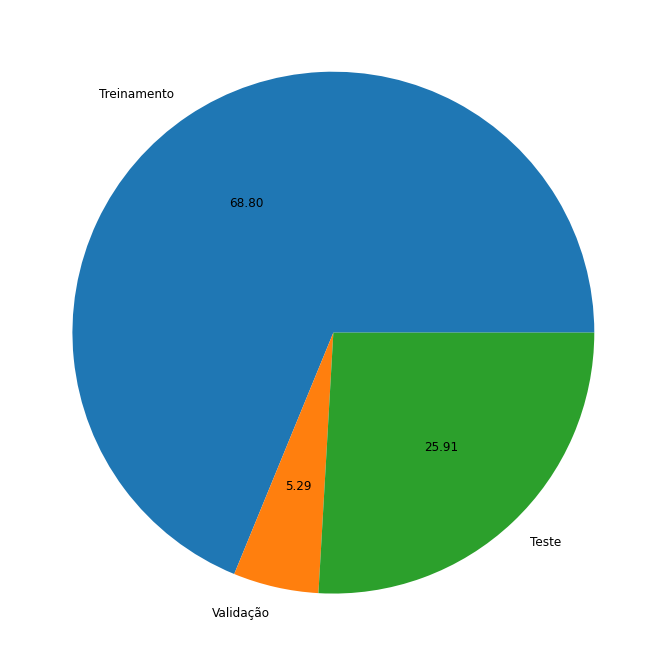

In [8]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Treinamento', 'Validação', 'Teste'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

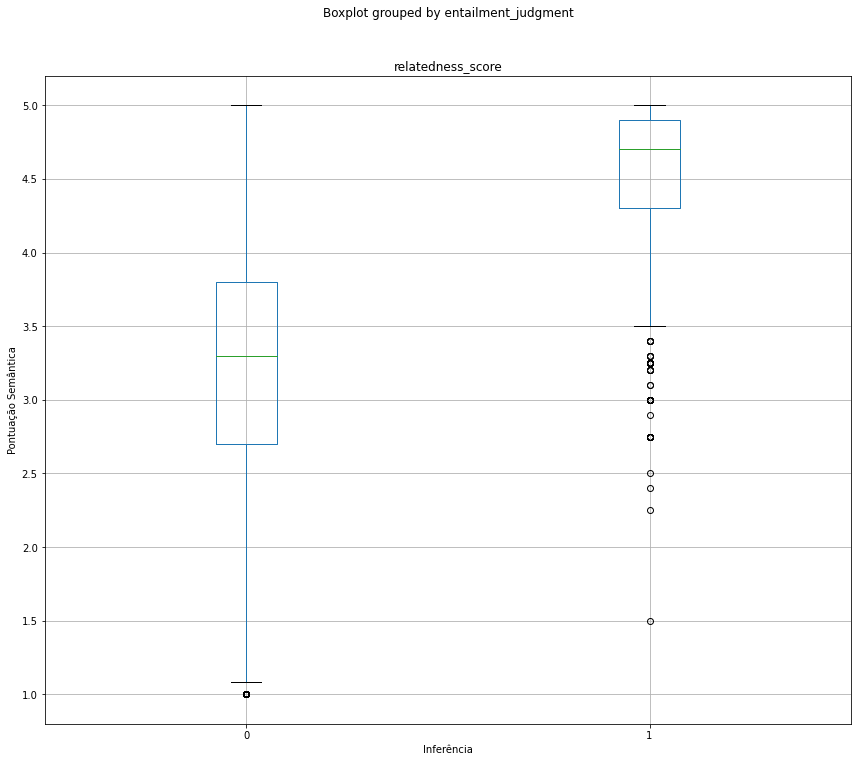

In [9]:
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

final_df = pd.concat([train_df, val_df, test_df])
# scaler = MinMaxScaler()
# norm_df = final_df.copy()

# norm_df['relatedness_score'] = scaler.fit_transform(norm_df['relatedness_score'].values.reshape(-1, 1))

# box_q1 = norm_df['relatedness_score'].quantile(0.25)
# box_q3 = norm_df['relatedness_score'].quantile(0.75)
# box_iqr = box_q3 - box_q1

# lower_whisker = box_q1-1.5*box_iqr
# upper_whisker = box_q3+1.5*box_iqr

# norm_df = norm_df.query("`relatedness_score` < @upper_whisker and `relatedness_score` > @lower_whisker")  # [norm_df['relatedness_score'] < upper_whisker & norm_df['relatedness_score'] > lower_whisker]

# norm_df = norm_df[norm_df['relatedness_score'] < upper_whisker]
# norm_df = norm_df[norm_df['relatedness_score'] > lower_whisker]

final_df.boxplot(column='relatedness_score', by='entailment_judgment')

plt.xlabel('Inferência')
plt.ylabel('Pontuação Semântica')
plt.show()

# Pre-processamento

In [10]:
def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def pre_processing(dataset, task):
    encoded_dataset = dataset.map(encoder, batched=True)

    if task == 'stsb':
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['relatedness_score']}, batched=True)
    else:
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)
    
    return encoded_dataset

tokenizer = AutoTokenizer.from_pretrained(training_model['checkpoint'], model_max_length=train_size)
encoded_dataset = pre_processing(dataset, TASK)

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Select Hyperparameters

In [11]:
def load_metrics(task):
    if task == 'stsb':
        metrics = evaluate.load('pearsonr')
    else:
        metrics = evaluate.combine(['accuracy', 'f1'])
    
    return metrics

def load_model(model_checkpoint, total_train_steps, task, learning_rate):
    from_pt = True if model_checkpoint == "neuralmind/bert-large-portuguese-cased" else False
    optimizer, schedule = create_optimizer(
        init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if task == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1, from_pt=from_pt)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    else:
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

def load_tf_dataset(dataset, model, data_collator, batch_size, shuffle):
    tf_dataset = model.prepare_tf_dataset(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return tf_dataset

def load_results(model, labels, task, tf_dataset):
    metrics = load_metrics(task)

    loss = model.evaluate(tf_dataset)
    predictions = model.predict(tf_dataset)
    
    if task == "stsb":
        predictions = predictions[0][:, 0]
    else:
        predictions = np.argmax(predictions[0], axis=1)

    results = metrics.compute(predictions=predictions, references=labels)
    results['loss'] = loss

    return results

def save_results(model_id, task, history, test_results, batch_size, learning_rate, num_epochs=5):
    history['id'] = [model_id for i in range(0,num_epochs)]
    history['batch_size'] = [batch_size for i in range(0,num_epochs)]
    history['learning_rate'] = [learning_rate for i in range(0,num_epochs)]
    train_dataframe = pd.DataFrame(history)
    train_dataframe.to_csv(f'./drive/MyDrive/models/train_{task}.csv', mode='a', index=False, header=False)
    
    test_results['id'] = model_id
    test_results['batch_size'] = batch_size
    test_results['learning_rate'] = learning_rate
    test_results = {key: [value] for key, value in test_results.items()}
    test_dataframe = pd.DataFrame(test_results)
    test_dataframe.to_csv(f'./drive/MyDrive/models/test_{task}.csv', mode='a', index=False, header=False)

In [12]:
class MetricsCallback:
    def __init__(self, task):
        self.task = task
        self.metrics = load_metrics(task)
    
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions
        if self.task == "stsb":
            predictions = predictions[:, 0]
        else:
            predictions = np.argmax(predictions, axis=1)

        return self.metrics.compute(predictions=predictions, references=labels)

In [13]:
# Hyperparams
LEARNING_RATES = [
    {"id": 2, "value": 2e-5},
    {"id": 3, "value": 3e-5},
    {"id": 4, "value": 4e-5}, 
    {"id": 5, "value": 5e-5},
]

BATCH_SIZES = [
    8,
    16,
    # 32,
    # 64
]

In [ ]:
NUM_EPOCHS = 5
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

for batch in BATCH_SIZES:
    batches_per_epoch = train_size // batch
    total_train_steps = int(batches_per_epoch * NUM_EPOCHS)
    for lr in LEARNING_RATES:
        # init model
        model_name = "{}-{}-{}-{}".format(training_model['id'], TASK, batch, lr['id'])
        print(model_name)
        
        model = load_model(training_model['checkpoint'], total_train_steps, TASK, lr['value'])
        output_path = f'./drive/MyDrive/models/{model_name}'
        
        # set dataset to tensor
        tf_train_set = load_tf_dataset(encoded_dataset['train'], model, data_collator, batch, shuffle=True)
        tf_validation_set = load_tf_dataset(encoded_dataset['validation'], model, data_collator, batch, shuffle=True)
        tf_test_set = load_tf_dataset(encoded_dataset['test'], model, data_collator, batch, shuffle=False)

        metrics_callback = MetricsCallback(TASK)
        callbacks = [
            KerasMetricCallback(metric_fn=metrics_callback.compute, eval_dataset=tf_validation_set)
        ]
        
        # training
        history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)
        
        # Evaluating
        labels = encoded_dataset['test']['label']
        test_results = load_results(model, labels, TASK, tf_test_set)
        
        # save results
        save_results(training_model['id'], TASK, history.history, test_results, batch, lr['value'], num_epochs=NUM_EPOCHS)

mbert-base-finetuned-pt_br-rte-8-2


## Analyzing data

In [ ]:
train_stsb_names = ['loss', 'val_loss', 'pearsonr', 'id', 'batch_size', 'learning_rate']
test_stsb_names = ['pearsonr', 'loss', 'id', 'batch_size', 'learning_rate']

train_rte_names = ['loss', 'val_loss', 'accuracy', 'f1', 'id', 'batch_size', 'learning_rate']
test_rte_names = ['accuracy', 'f1', 'loss', 'id', 'batch_size', 'learning_rate']

# Fine-tuning

Huggingface Login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Git config for upload model

In [ ]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [ ]:
def load_callbacks(model_name, output_path, task, validation_set, tokenizer):
    metrics = MetricsCallback(task)
    metrics_callback = KerasMetricCallback(
        metric_fn=metrics.compute, eval_dataset=validation_set
    )

    tensorboard_callback = TensorBoard(log_dir=f"{output_path}/logs")

    push_to_hub_callback = PushToHubCallback(
        output_dir=f'./{model_name}',
        tokenizer=tokenizer,
        hub_model_id=model_name,
        save_strategy="no"
    )

    callbacks = [metrics_callback, tensorboard_callback, push_to_hub_callback]
    
    return callbacks

## Testing

In [ ]:
def plot_loss(history, label='Loss'):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], label='Val ' + label)
  
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()
  plt.show()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();
    plt.show()

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  print('True Negatives:', cm[0][0])
  print('False Positives:', cm[0][1])
  print('False Negatives:', cm[1][0])
  print('True Positives:', cm[1][1])

In [ ]:
# if TASK == 'rte':
#     plot_confusion_matrix(y, preds)